# Modèle SVM


In [1]:
# Installation et chargement des requirements
%pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             confusion_matrix, classification_report, f1_score)

Note: you may need to restart the kernel to use updated packages.


#  CHARGEMENT ET PRÉPARATION

In [2]:
df = pd.read_csv("all_expenses_profil.csv")

# Définition cible et features
y = df["profil"]
X = df.drop(["TOTEXP23", "profil", "DUPERSID", "cum_cost_share"], axis=1, errors="ignore")

# Split Train/Test (Même graine 42 pour comparaison stricte)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print(f"Train set: {X_train.shape[0]} individus. Test set: {X_test.shape[0]} individus.")

Train set: 5698 individus. Test set: 1900 individus.


# 2. PIPELINE DE PRÉTRAITEMENT (Log-Transformation + Scaling)

In [5]:
# Les SVM détestent les distributions asymétriques (skewed).
# On applique Log1p -> StandardScaler pour aider le SVM à trouver la frontière.

# Identification des types de colonnes
all_num_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_vars = X.select_dtypes(include=["object", "category"]).columns.tolist()

# On isole la variable 'tendance' qui peut être négative (si elle existe)
vars_negative = [col for col in all_num_vars if "tendance" in col]
vars_positive = [col for col in all_num_vars if col not in vars_negative]

print(f"Variables log-transformées (positives) : {len(vars_positive)}")
print(f"Variables standardisées uniquement (négatives/mixtes) : {len(vars_negative)}")

# Transformateur Logarithmique (Uniquement pour les positives)
log_transformer = FunctionTransformer(np.log1p, validate=True)

# Pipeline pour variables POSITIVES (Dépenses...) -> Log + Scaler
numeric_pos_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

# Pipeline pour variables NÉGATIVES (Tendance...) -> Scaler uniquement
numeric_neg_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)), # Ou median
    ("scaler", StandardScaler())
])

# Pipeline Catégoriel
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Assemblage intelligent
preproc_svm = ColumnTransformer(
    transformers=[
        ("num_pos", numeric_pos_transformer, vars_positive),
        ("num_neg", numeric_neg_transformer, vars_negative),
        ("cat", categorical_transformer, cat_vars)
    ]
)

Variables log-transformées (positives) : 127
Variables standardisées uniquement (négatives/mixtes) : 1


# 3. MODÉLISATION ET GRID SEARCH

In [6]:
# Pipeline complet
# On utilise LinearSVC car beaucoup plus rapide que SVC pour n_samples > 1000
# dual=False est recommandé quand n_samples > n_features
pipe_svm = Pipeline([
    ('preprocess', preproc_svm),
    ('svc', LinearSVC(max_iter=5000, dual=False, random_state=42))
])

# Grille d’hyperparamètres
parameters_svm = {
    'svc__C': [0.01, 0.1, 1, 10], # Pénalité
    'svc__class_weight': [None, 'balanced'] # Test crucial pour le déséquilibre
}

print("\n--- Démarrage du Grid Search (SVM) ---")
clf_svm = GridSearchCV(
    estimator=pipe_svm,
    param_grid=parameters_svm,
    cv=5,
    scoring="f1_macro", # On optimise le F1 Macro directement
    n_jobs=-1,
    verbose=1
)

clf_svm.fit(X_train, y_train)


--- Démarrage du Grid Search (SVM) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/impute/_base.py:590: FutureWarning: 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svc__C': [0.01, 0.1, ...], 'svc__class_weight': [None, 'balanced']}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num_pos', ...), ('num_neg', ...), ...]"


# 4. RÉSULTATS


=== Résultats SVM (LinearSVC) ===
Meilleurs paramètres : {'svc__C': 0.1, 'svc__class_weight': 'balanced'}
Meilleur score CV (F1 Macro) : 0.3139

--- Performances sur le Test Set ---
Accuracy : 0.7763
Macro F1-Score : 0.3004

=== Classification Report ===
              precision    recall  f1-score   support

      Faible       0.80      0.97      0.87      1519
       Moyen       0.05      0.01      0.02       209
       Élevé       0.07      0.01      0.01       172

    accuracy                           0.78      1900
   macro avg       0.31      0.33      0.30      1900
weighted avg       0.65      0.78      0.70      1900



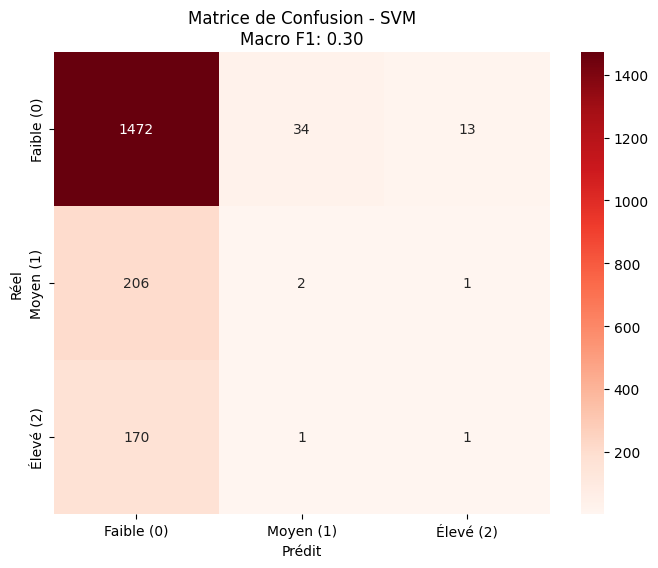

In [7]:
print("\n=== Résultats SVM (LinearSVC) ===")
print(f"Meilleurs paramètres : {clf_svm.best_params_}")
print(f"Meilleur score CV (F1 Macro) : {clf_svm.best_score_:.4f}")

# Prédictions
y_pred = clf_svm.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
macro_f1_svm = f1_score(y_test, y_pred, average="macro")

print("\n--- Performances sur le Test Set ---")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1-Score : {macro_f1_svm:.4f}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Faible', 'Moyen', 'Élevé']))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'],
            yticklabels=['Faible (0)', 'Moyen (1)', 'Élevé (2)'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion - SVM\nMacro F1: {macro_f1_svm:.2f}')
plt.show()